In [3]:
import pandas as pd
pd.options.plotting.backend = "plotly"
pd.set_option('display.max_columns', None)

import numpy as np

### Load data

In [2]:
X_train = pd.read_csv('../data/train_values.csv', index_col='building_id')
y_train = pd.read_csv('../data/train_labels.csv', index_col='building_id')

X_test = pd.read_csv('../data/test_values.csv', index_col='building_id')

## 1. Exploratory data analysis + feature engineering

In [3]:
X_train[['geo_level_1_id','geo_level_2_id','geo_level_3_id']] = X_train[['geo_level_1_id','geo_level_2_id','geo_level_3_id']].astype(str)
X_test[['geo_level_1_id','geo_level_2_id','geo_level_3_id']] = X_test[['geo_level_1_id','geo_level_2_id','geo_level_3_id']].astype(str)

X_train[['count_floors_pre_eq','age','area_percentage','height_percentage']] = X_train[['count_floors_pre_eq','age','area_percentage','height_percentage']].astype(float)

X_train['volume_percentage']=X_train['area_percentage'] * X_train['height_percentage']
X_test['volume_percentage']=X_test['area_percentage'] * X_test['height_percentage']

# Categorical columns 
categorical_columns = [c for c in X_train.select_dtypes(include=['object'])]
numerical_columns= list(set(X_train.columns) - set(categorical_columns))

### Factor analysis of mixed data (FAMD)

In [4]:
from sklearn.utils import resample

def sub_sample(X, y, num_):
    data = pd.concat([X, y], axis=1)

    # Separate classes
    damage_3 = data[data['damage_grade']==3]
    damage_2 = data[data['damage_grade']==2]
    damage_1  = data[data['damage_grade']==1]
 
    damage_1_sample = resample(damage_1, 
                               replace=False,
                               n_samples=num_)
    
    damage_2_sample = resample(damage_2, 
                               replace=False,
                               n_samples=num_)    

    damage_3_sample = resample(damage_3, 
                               replace=False,
                               n_samples=num_)

    # Combine majority class with upsampled minority classes
    data_upsampled = pd.concat([damage_1_sample, damage_2_sample, damage_3_sample])

    y_sampled = data_upsampled[['damage_grade']]
    X_sampled = data_upsampled.drop(['damage_grade'], axis=1)

    return (X_sampled, y_sampled)

X_train_sub, y_train_sub = sub_sample(X=X_train,y=y_train,num_=1000)

In [5]:
import prince

famd = prince.FAMD( n_components=2, n_iter=3, copy=True,
                   check_input=True, random_state=42, engine="sklearn")

famd = famd.fit(X_train_sub)

/home/marc/miniconda3/envs/dsr/lib/python3.11/site-packages/prince/pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-1.3016655996581201, -3.8065294779715906, -0.8348652585896722, -0.3011090610836324, -0.130384048104053, -0.1064581294844754, -0.432434966208793, -1.206786366070372, -3.5404331185134206, -1.1316654393709595, -1.2415044636783767, -0.4993328882953068, -0.47609522856952335, -1.1291589790636214, -0.7639808025511287, -0.9371943946339699, -0.3449637662132068, -0.3530816713830763, -0.532290647422377, -1.1613210868087545, -0.4516635916254486, -0.1991649232838621, -0.2129162589689508, -1.1949895397031725, -0.9095786570348566, -0.6207522318391884, -0.16832508230603466, -0.5049752469181039, -1.5242484486898231, -0.8314645713037527, -0.6519202405202649, -0.3103761159195942, -0.848331696134635, -0.48200968178381376, -1.220792092591254, -0.9958246164193104, -1.0538817137927132, -0.0752772652709081, -0.31937438845342625, -0.1505545305418162, -0.271

### Plot data in FAMD space

In [6]:
import plotly.express as px

X_train_2d = famd.row_coordinates(X_train_sub)
X_train_2d.columns = ["C1","C2"]
X_train_2d = pd.concat([X_train_2d, y_train_sub], axis=1) 

px.scatter(X_train_2d, x='C1', y='C2', color='damage_grade',
           width=800,height=500, title="Factor analysis of mixed data").show()

/home/marc/miniconda3/envs/dsr/lib/python3.11/site-packages/prince/pca.py:175: PerformanceWarning: Concatenating sparse arrays with multiple fill values: '[-1.3016655996581201, -3.8065294779715906, -0.8348652585896722, -0.3011090610836324, -0.130384048104053, -0.1064581294844754, -0.432434966208793, -1.206786366070372, -3.5404331185134206, -1.1316654393709595, -1.2415044636783767, -0.4993328882953068, -0.47609522856952335, -1.1291589790636214, -0.7639808025511287, -0.9371943946339699, -0.3449637662132068, -0.3530816713830763, -0.532290647422377, -1.1613210868087545, -0.4516635916254486, -0.1991649232838621, -0.2129162589689508, -1.1949895397031725, -0.9095786570348566, -0.6207522318391884, -0.16832508230603466, -0.5049752469181039, -1.5242484486898231, -0.8314645713037527, -0.6519202405202649, -0.3103761159195942, -0.848331696134635, -0.48200968178381376, -1.220792092591254, -0.9958246164193104, -1.0538817137927132, -0.0752772652709081, -0.31937438845342625, -0.1505545305418162, -0.271

### show contributions to each component

In [7]:
cp_contribution = famd.column_contributions_
cp_contribution.columns = ["C1","C2"]
print("Features contibuting to C1")
cp_contribution.C1[cp_contribution.C1 > 0.005].sort_values(ascending=False)

Features contibuting to C1


variable
geo_level_3_id       0.008093
foundation_type      0.006557
roof_type            0.006494
ground_floor_type    0.006341
other_floor_type     0.005964
geo_level_2_id       0.005939
Name: C1, dtype: float64

In [8]:
print("Features contibuting to C2")
cp_contribution.C2[cp_contribution.C2 > 0.005].sort_values(ascending=False)

Features contibuting to C2


variable
geo_level_3_id     0.014831
geo_level_2_id     0.013754
geo_level_1_id     0.009466
foundation_type    0.007587
Name: C2, dtype: float64

### Split the data

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, test_size=0.2, random_state=0)

### Try to fix class imbalance using upsampling

In [10]:
from sklearn.utils import resample

def upsample(X_train, y_train):
    data = pd.concat([X_train, y_train], axis=1)

    # Separate classes
    damage_3 = data[data['damage_grade']==3]
    damage_2 = data[data['damage_grade']==2]
    damage_1  = data[data['damage_grade']==1]
 
    # Upsample miniroty class, damage=1
    damage_1_upsampled = resample(damage_1, 
                                  replace=True,     # sample with replacement
                                  n_samples=damage_2.shape[0]) # reproducible results
    
    # Upsample miniroty class, damage=3
    damage_3_upsampled = resample(damage_3, 
                                  replace=True,     # sample with replacement
                                  n_samples=damage_2.shape[0]) # reproducible results

    # Combine majority class with upsampled minority classes
    data_upsampled = pd.concat([damage_1_upsampled, damage_2, damage_3_upsampled])

    y_train_upsampled = data_upsampled[['damage_grade']]
    X_train_upsampled = data_upsampled.drop(['damage_grade'], axis=1)

    return (X_train_upsampled, y_train_upsampled)

#X_train, y_train = upsample(X_train=X_train, y_train=y_train)

All possible values from all categorical columns are present in the train set

## Encode categorical values

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import TargetEncoder

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('target', TargetEncoder(target_type="continuous"))
])

# Bundle preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_columns),
        ("numerical", "passthrough", numerical_columns),
    ])



# Modell training

In [2]:
# for preprocessing the data
#from sklearn.preprocessing import StandardScaler

# the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


model = RandomForestClassifier(max_depth=None, n_estimators=300, random_state=57)

clf = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('classifier', model)])


#param_grid = {
#    'classifier__n_estimators': [200, 300, 400],
#    'classifier__max_depth': [None, 50, 100]
#}
#
#grid_search = GridSearchCV(clf, param_grid, 
#                           cv=2, n_jobs=1,
#                           scoring='f1_micro',verbose=3)

clf.fit(X_train, y_train['damage_grade'])

NameError: name 'Pipeline' is not defined

### Calculate F1 Score for validation set

In [13]:
from sklearn.metrics import f1_score

pred_valid = clf.predict(X_valid)
my_f1_score = f1_score(y_valid, pred_valid, average='micro')
print(f"F1 score: {my_f1_score}")



F1 score: 0.743481514168953


### Confussion matrix

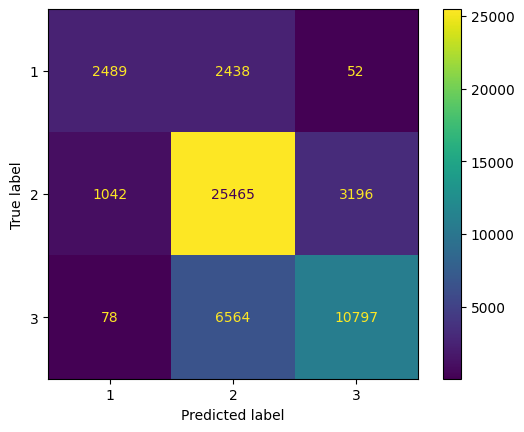

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_valid, y_valid)

### Prediction on validation and test data

In [1]:
pred_test = clf.predict(X_test)

my_submission = pd.DataFrame(data=pred_test,
                             columns=['damage_grade'],
                             index=X_test.index)

my_submission.to_csv('submission.csv')

pred_valid = clf.predict(X_valid)

pred_valid_df = pd.DataFrame(data=pred_valid,
                             columns=['damage_grade'],
                             index=X_test.index)

pred_valid_df.to_csv('pred_valid_df.csv')

NameError: name 'clf' is not defined